<a href="https://colab.research.google.com/github/TViraj/BiometricAuthentication/blob/master/Copy_of_human_horse_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import drive
import zipfile
import os

# Path to the zip file you uploaded
zip_file_path = '/content/drive/MyDrive/horse-or-human.zip'

# Directory to extract the contents
extract_dir = '/content/extracted_files/'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all contents to the specified directory
    zip_ref.extractall(extract_dir)

print("Extraction complete.")


Extraction complete.


# Data Exploration:

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Path to the directory containing the dataset
data_dir = '/content/extracted_files'

In [ ]:


# List of classes (assuming two classes: 'humans' and 'horses')
classes = ['humans', 'horses']


In [ ]:
# Dictionary to store class counts
class_counts = {cls: 0 for cls in classes}

In [ ]:
# Dictionary to store image dimensions
image_dimensions = []


In [ ]:
# Function to load and visualize sample images
def visualize_samples():
    plt.figure(figsize=(10, 5))
    for i, cls in enumerate(classes, start=1):
        # Get a list of image files in the class directory
        class_path = os.path.join(data_dir, cls)
        image_files = os.listdir(class_path)
        # Select a random sample image
        sample_image = cv2.imread(os.path.join(class_path, image_files[0]))
        # Store image dimensions
        image_dimensions.append(sample_image.shape[:2])
        # Plot the image
        plt.subplot(1, len(classes), i)
        plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
        plt.title(cls.capitalize())
        plt.axis('off')
        # Update class counts
        class_counts[cls] = len(image_files)
    plt.show()

In [ ]:
# Function to plot class distribution
def plot_class_distribution():
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.show()

In [ ]:
# Function to check image properties
def check_image_properties():
    print("Image Dimensions:")
    for cls, dimensions in zip(classes, image_dimensions):
        print(f"{cls.capitalize()} - Height: {dimensions[0]}, Width: {dimensions[1]}")

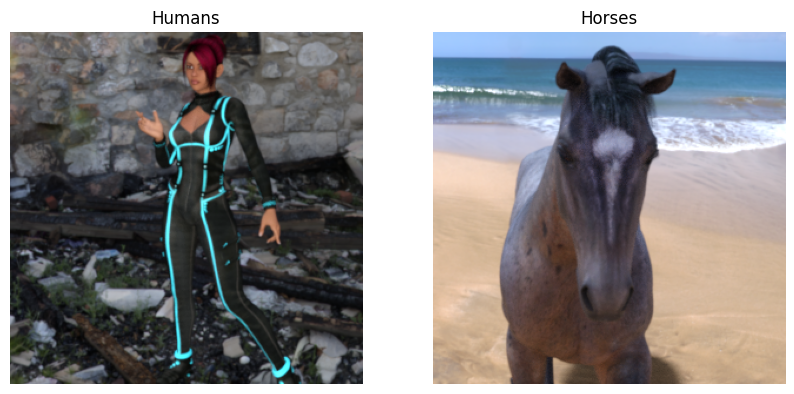

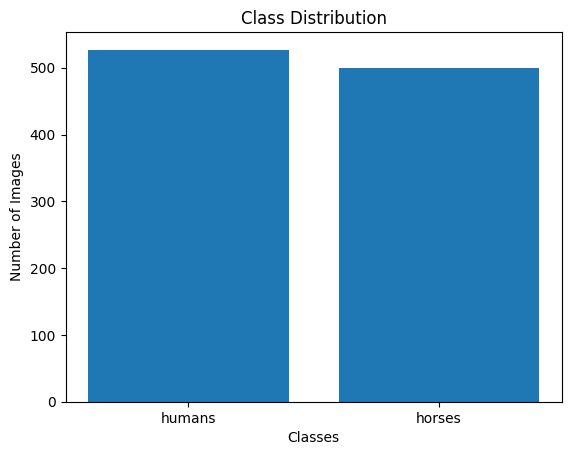

Image Dimensions:
Humans - Height: 300, Width: 300
Horses - Height: 300, Width: 300


In [ ]:
# Perform data exploration
visualize_samples()
plot_class_distribution()
check_image_properties()

# Data Preprocessing:

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths to the dataset
data_dir = '/content/extracted_files'
human_dir = os.path.join(data_dir, 'humans')
horse_dir = os.path.join(data_dir, 'horses')

# Function to load and preprocess images
def load_and_preprocess_data(image_size, batch_size):
    # Initialize lists to store images and labels
    images = []
    labels = []

    # Load images of humans
    for img_name in os.listdir(human_dir):
        img_path = os.path.join(human_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (image_size, image_size))
        img = img.astype('float32') / 255.0  # Normalize pixel values
        images.append(img)
        labels.append(0)  # Human label is 0

    # Load images of horses
    for img_name in os.listdir(horse_dir):
        img_path = os.path.join(horse_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (image_size, image_size))
        img = img.astype('float32') / 255.0  # Normalize pixel values
        images.append(img)
        labels.append(1)  # Horse label is 1

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.15, random_state=42)

    # Data augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)

    return train_generator, X_test, y_test

# Example usage
image_size = 224  # Size to resize images
batch_size = 32   # Batch size for training
train_generator, X_test, y_test = load_and_preprocess_data(image_size, batch_size)


# Model Selection: using CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
def create_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
    ])
    return model

In [ ]:
# Define input shape based on image size
input_shape = (224, 224, 3)  # Assuming images are resized to 224x224 pixels and have 3 color channels (RGB)

# Create the CNN model
model = create_cnn_model(input_shape)

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

# Model Building:

In [ ]:
import matplotlib.pyplot as plt


Epoch 1/10
28/28 [==============================] - 129s 4s/step - loss: 0.8628 - accuracy: 0.5069 - val_loss: 0.6629 - val_accuracy: 0.6581
Epoch 2/10
28/28 [==============================] - 127s 4s/step - loss: 0.5687 - accuracy: 0.7225 - val_loss: 0.3362 - val_accuracy: 0.8387
Epoch 3/10
28/28 [==============================] - 141s 5s/step - loss: 0.5152 - accuracy: 0.7443 - val_loss: 0.2843 - val_accuracy: 0.9097
Epoch 4/10
28/28 [==============================] - 131s 5s/step - loss: 0.4142 - accuracy: 0.8200 - val_loss: 0.1107 - val_accuracy: 0.9806
Epoch 5/10
28/28 [==============================] - 131s 5s/step - loss: 0.2681 - accuracy: 0.8727 - val_loss: 0.1601 - val_accuracy: 0.9677
Epoch 6/10
28/28 [==============================] - 126s 4s/step - loss: 0.3297 - accuracy: 0.8796 - val_loss: 0.1454 - val_accuracy: 0.9613
Epoch 7/10
28/28 [==============================] - 125s 4s/step - loss: 0.2345 - accuracy: 0.9140 - val_loss: 0.0454 - val_accuracy: 0.9935
Epoch 8/10
28

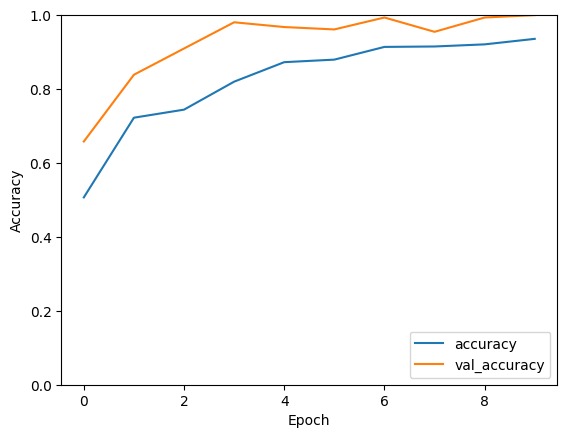

In [ ]:
# Train the model
history = model.fit(train_generator, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


Test Loss: 0.028390826657414436
Test Accuracy: 1.0
5/5 [==============================] - 7s 1s/step
Confusion Matrix:
[[73  0]
 [82  0]]


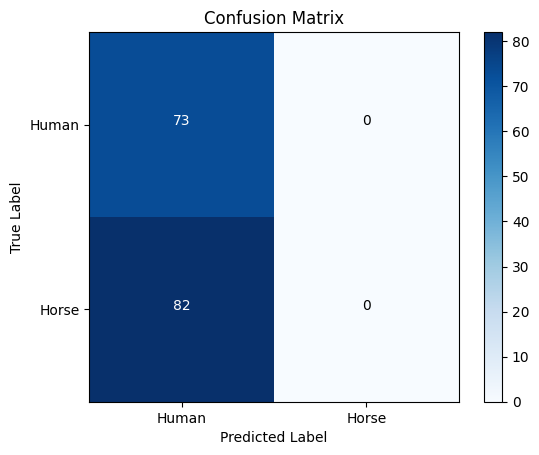

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 1. Analyze Performance Metrics
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# 2. Error Analysis
y_pred = np.argmax(model.predict(X_test), axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0, 1], ['Human', 'Horse'])
plt.yticks([0, 1], ['Human', 'Horse'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")
plt.show()

In [ ]:
# Save the model
model.save('human_horse_classifier.h5')
print("Model saved successfully.")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully.


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('human_horse_classifier.h5')


In [ ]:
# prompt: how to compress my human_horse_classifier.h5 model

!zip -r human_horse_classifier.zip human_horse_classifier.h5


  adding: human_horse_classifier.h5 (deflated 17%)


In [ ]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.8 MB/s eta 0:00:00


In [ ]:
! pip install streamlit -q

In [ ]:
!wget -q -O - ipv4.icanhazip.com

34.125.117.254


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501

[..................] \ fetchMetadata: sill resolveWithNewModule yargs@17.1.1 ch

npx: installed 22 in 5.166s

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.117.254:8501

your url is: https://fifty-things-judge.loca.lt
2024-02-21 20:03:33.602510: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 20:03:33.602574: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 20:03:33.604039: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-21 20:03:35.009090: W tensorflow/compiler/tf2tensorrt/utils/